<a href="https://colab.research.google.com/github/vitalivu/short-sentences-similarity/blob/master/aai_semantic_similarity_for_short_sentences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AAI Short Sentence Similarity
=======



## Project Requirement

Python `pip`:
- `sentence_transformers`: a BERT based model, to convert output of BERT based (eg BERT/RoBERTa) to a fixed-size vector
- `pandas`: working with file in CSV format
- `pytorch`, `numpy`: for caculation
- `sklearn`: using `k-fold` cross validation to build and evaluate the model

For original paper of Sentence-BERT, see [arxiv.org](https://arxiv.org/abs/1908.10084)
For the translation version, see [TODO lvt: insert drive link of PDF](#)

Install requirements packages with pip:

In [ ]:
!pip install sentence_transformers

## Project Overview



### Real world problem
1. Quora is a social network for people to ask and answer
  - Typically, after an user submits a question, he has to wait for someone else answer his question
  - Time fly, at the moment Quora has a huge dataset of quesions from its users:
    - Some question is new
    - Some question is asked over and over => it's duplicated, and already has the answer.
  - Whenever an user want to ask a new question, 
    - if Quora can provide the similar questions for users (based on their huge dataset of question), user will able to browse the duplicate question's answer without waiting for someone else to answer. It's really helpful to provide the similar question to their question.
    
2. Question based system:
  - Given a dataset of pairs question-and-answer.
  - User was asking to answer a question.
    - User provides an answer and submit to system.
  - The system bases on the model to rate is the user's answer is similar with the answer in dataset.
      - The rating in range of [0,1], with 1 means very similar.

### Problem
- Domain: Natual Language Processing
- Problem: Semantic similarity between short sentences
- Data:
  - The quora's dataset
    - provided in CSV format
      - for each line, given 2 questions and a flag indicate that is the 2 questions is duplicate or not
    - contains both training/test set in zip format, see the list of file below:

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/gdrive/MyDrive/Colab Notebooks/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Example data in training set

In [ ]:
df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/data/quora/input/train.csv.zip', compression='zip', sep=',')
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


## Problem Statement

> Given 2 short sentences (2 questions for more detail)
> Predict that is the provided sentences is similar?.

- Problem is a **binary classification** task.
- Input: 2 questions
- Ouput: flag indicate the 2 question is duplicated or not.

## Data Understanding

### Format of data
CSV - can be process directly with `pandas`

### Quality of data

Some statistics from dataset

Total pair of question: 404290
Total duplicated pairs: 36.92%
Total unique questions: 537933
Total non-unique/repeated questions: 111780



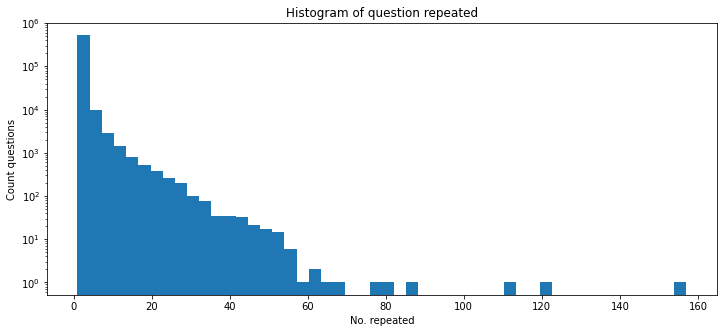

In [ ]:
import matplotlib.pyplot as plt

print('Total pair of question: {}'.format(len(df)))
print('Total duplicated pairs: {}%'.format(round(df['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Total unique questions: {}'.format(len(np.unique(qids))))
print('Total non-unique/repeated questions: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log')
plt.title('Histogram of question repeated')
plt.xlabel('No. repeated')
plt.ylabel('Count questions')
print()

Using tf-idf to find the least common words

In [ ]:
from collections import Counter

questions = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)

words = (" ".join(questions)).lower().split()
counts = Counter(words)
weights = {word: count for word, count in counts.items()}
(sorted(weights.items(), key=lambda x: x[1], reverse=False)[:10])

[('rising...what', 1),
 ('tiago?', 1),
 ('motorolla', 1),
 ('dcx3400?', 1),
 ('biprism?', 1),
 ('(employment,', 1),
 ('me?",', 1),
 ('aoa', 1),
 ('rexnord', 1),
 ('israil', 1)]

### Semantic analysis


In [ ]:
qmarks = np.mean(questions.apply(lambda x: '?' in x))
fullstop = np.mean(questions.apply(lambda x: '.' in x))
numbers = np.mean(questions.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with full stops: 6.31%
Questions with numbers: 11.83%


### Data pre-processing

Data need preprocessing:
- Data is case insentive, but provided in with both lower/uppercase characters => lowercase all character
- Data has special characters/punctuations and can be removed/replaced, eg `$` dollar, remove `?!~` => remove non ascii character
- Data has abbreviations, eg `wouldn't` (would not) => replace

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

from nltk.tokenize import word_tokenize

abbreviations = {
"'all": "all",
"'cause": "because",
"'ll": 'will',
"'m": "am",
"'re": "are",
"'s": 'is',
"'ve": 'have',
"'y": "you",
"ai": 'am',
"can't": "can not",
"couldn't": "could not",
"hadn't": "had not",
"he'll": 'he will',
"how'd'y": "how would you",
"i'll": 'i will',
"it'll": 'it will',
"mightn't": "might not",
"mustn't": "must not",
"n't": 'not',
"needn't": "need not",
"o'clock": "clock",
"oughtn't": "ought not",
"sha'n't": "will not",
"shan't": "will not",
"she'll": 'she will',
"shouldn't": "should not",
"they'll": 'they will',
"we'll": 'we will',
"what'll": "what will",
"who'll": "who will",
"won't": "will not",
"wouldn't": "would not",
"y'all": "you all",
"you'll": 'you will',
}

def de_abbrev(word):
    return abbreviations[word] if word.lower() in abbreviations.keys() else word

def clean_text(text):
    if not isinstance(text, str):
        return ""
    for c in [",", "!", ".", "?", '"', ":", ";", "[", "]", "{", "}", "<", ">"]:
        text = text.lower().replace(c, " ")
    tokens = word_tokenize(text)
    tokens = [de_abbrev(word) for word in tokens]
    text = " ".join(tokens)
    return str(text).replace(r'[^\x00-\x7f]', r' ') # remove all special chars

clean_text("What's the approx annual cost of living while studying in UIC Chicago, for an Indian student?")

then, create additional data column with cleaned data by mapping `question` to `clean_text(question)`

- List all the sentence (cleaned)
- Compute vector embeddings of each sentence

In [ ]:
from sentence_transformers import SentenceTransformer, util, CrossEncoder
from time import perf_counter

sbert_model = SentenceTransformer('paraphrase-distilroberta-base-v1')

sub_set_size = 2000
t00 = perf_counter()
cosine_sim = []
total_subset = len(df) // sub_set_size

for g, sub_df in df.groupby(np.arange(len(df)) // sub_set_size):

    t0 = perf_counter()

    question1 = sub_df['question1'].tolist()
    question2 = sub_df['question2'].tolist()
    cleaned_q1 = [clean_text(q) for q in question1]
    cleaned_q2 = [clean_text(q) for q in question2]

    embeddings1 = sbert_model.encode(cleaned_q1, convert_to_tensor=True)
    embeddings2 = sbert_model.encode(cleaned_q2, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    sub_cosine_sim = [cosine_scores[ir][ir].item() for ir in range(len(cleaned_q1))]

    t1 = perf_counter()
    print("subset bi encoder {}/{} {} process in {:.4f} seconds".format(g, total_subset,sub_df.shape, t1 - t0))

    #for ir in range(len(cleaned_q1)):
    #    print("{:.6f} | {} | {}".format(cosine_scores[ir][ir], cleaned_q1[ir], cleaned_q2[ir]))
    cosine_sim.extend(sub_cosine_sim)

t0z = perf_counter()
print("Total time {:.4f} seconds".format(t0z - t00))
df['cosine_sim'] = cosine_sim
df.head(10)

subset bi encoder 193/202 (2000, 6) process in 3.3943 seconds
subset bi encoder 194/202 (2000, 6) process in 3.3904 seconds
subset bi encoder 195/202 (2000, 6) process in 3.4566 seconds
subset bi encoder 196/202 (2000, 6) process in 3.3499 seconds
subset bi encoder 197/202 (2000, 6) process in 3.3640 seconds
subset bi encoder 198/202 (2000, 6) process in 3.4251 seconds
subset bi encoder 199/202 (2000, 6) process in 3.3719 seconds
subset bi encoder 200/202 (2000, 6) process in 3.4426 seconds
subset bi encoder 201/202 (2000, 6) process in 3.3305 seconds
subset bi encoder 202/202 (290, 6) process in 0.5823 seconds
Total time 684.3589 seconds


,id,qid1,qid2,question1,question2,is_duplicate,cosine_sim
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.954577
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.526763
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.624345
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.132098
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.286812
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,0.799678
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,-0.034585
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,0.944617
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,0.460974
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,0.639556


Visualize cosine-similarity score vs duplicate

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


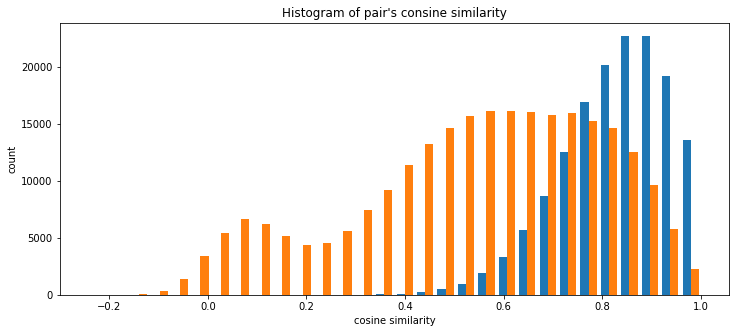

In [ ]:
is_duplicated = df['is_duplicate'].tolist()
duplicate_idx = [i for i,v in enumerate(is_duplicated) if v==1]
non_duplicate_idx = [i for i,v in enumerate(is_duplicated) if v==0]

cosine_sim_duplicate = [cosine_sim[idx] for idx in duplicate_idx]
cosine_sim_nonduplicate = [cosine_sim[idx] for idx in non_duplicate_idx]

plt.figure(figsize=(12, 5))
# plt.yscale('log')
plt.hist([cosine_sim_duplicate, cosine_sim_nonduplicate], bins=30, label=['duplicate', 'non-duplicate'])
plt.title("Histogram of pair's consine similarity")
plt.xlabel('cosine similarity')
plt.ylabel('count')
print()

In [ ]:
cross_encoder = CrossEncoder('cross-encoder/quora-distilroberta-base')

sub_set2_size = 100 if sub_set_size > 100 else sub_set_size
total_subset = len(df) // sub_set2_size

t00 = perf_counter()
cross_sim = []
for g, sub_df in df.groupby(np.arange(len(df)) // sub_set2_size):

    t0 = perf_counter()

    sub_cleaned_q1 = [clean_text(q) for q in sub_df['question1']]
    sub_cleaned_q2 = [clean_text(q) for q in sub_df['question2']]
    sentence_combinations = [[q1, q2] for q1,q2 in zip(sub_cleaned_q1, sub_cleaned_q2)]

    cross_scores = cross_encoder.predict(sentence_combinations)
    sub_cross_sim = [cross.item() for cross in cross_scores]

    t1 = perf_counter()
    print("subset cross encoder {}/{} {} process in {:.4f} seconds".format(g, total_subset, sub_df.shape, t1 - t0))
    cross_sim.extend(sub_cross_sim)

t0z = perf_counter()
print("Total time {:.4f} seconds".format(t0z - t00))
df['cross_sim'] = cross_sim
df.head(10)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


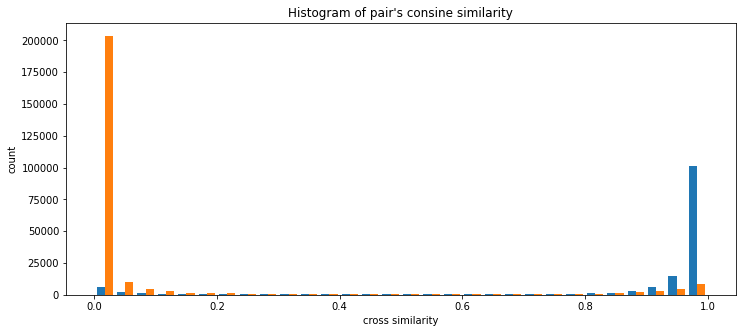

In [ ]:
cross_sim_duplicate = [cross_sim[idx] for idx in duplicate_idx]
cross_sim_nonduplicate = [cross_sim[idx] for idx in non_duplicate_idx]

plt.figure(figsize=(12, 5))
# plt.yscale('log')
plt.hist([cross_sim_duplicate, cross_sim_nonduplicate], bins=30, label=['duplicate', 'non-duplicate'])
plt.title("Histogram of pair's consine similarity")
plt.xlabel('cross similarity')
plt.ylabel('count')
print()

## Modeling

Find the model to fit cross-similarity to is_duplicate:
- Using `LogisticRegression`
- evaluate model with [LogLoss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)

In [ ]:
compression_opts = dict(method='zip', archive_name='train.csv') 
df.to_csv('/gdrive/MyDrive/Colab Notebooks/data/quora/output/train.csv.zip', index=False, compression=compression_opts)

In [1]:
from google.colab import drive
drive.mount('/gdrive')

import numpy as np
import pandas as pd
import os

# open exported file
df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/data/quora/output/train.csv.zip', compression='zip', sep=',')
df.head(10)

Mounted at /gdrive


,id,qid1,qid2,question1,question2,is_duplicate,cosine_sim,cross_sim
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.954577,0.007003
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.526763,0.000424
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.624345,0.000874
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.132098,0.000243
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.286812,0.000241
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,0.799678,0.983176
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,-0.034585,0.000297
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,0.944617,0.988464
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,0.460974,0.000365
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,0.639556,0.878037


In [6]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
X = np.array(df['cosine_sim'])
X = X.reshape(-1,1)
y = np.array(df['is_duplicate'])

lr_model = LogisticRegression()

from sklearn.metrics import log_loss
scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    lr_model.fit(X_train, y_train)
    y_pred = lr_model .predict(X_test)
    print(lr_model.coef_, lr_model.intercept_)
    print(log_loss(y_test, y_pred))
    fit = 0
    for yt, yp in zip(y_test, y_pred):
        fit += 1 if yt==yp else 0
    scores.append(fit/len(y_test))
print("AVG Acuracy", np.average(scores))

[[9.24881315]] [-7.22201531]
8.16641876758657
[[9.20466302]] [-7.1864161]
8.027165555080261
[[9.20422903]] [-7.1894045]
8.087820103780468
[[9.26999603]] [-7.23784242]
8.256549200897481
[[9.22834066]] [-7.20526873]
8.098500562657156
[[9.23587423]] [-7.2105224]
8.11729575105735
[[9.2252978]] [-7.20365828]
8.114731791818938
[[9.23822823]] [-7.21170661]
8.114305933782237
[[9.20735278]] [-7.1897478]
8.069453255533213
[[9.21428763]] [-7.19570908]
8.059628992405848
AVG Acuracy 0.7651599099656188


## Model Evaluation and Validation

## Deploy model

See the example
https://semantic-similarity-search.netlify.app/search?random&alt

## Conclusion
- 76% accuray but log loss is not not good enough
- Need to investigate more on how to improve the model, see discussion in [kaggle](https://www.kaggle.com/c/quora-question-pairs/discussion/30340)